In [605]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
import scipy.optimize as spo
from scipy.stats import exponweib

In [514]:
#ESTIMACIÓN DE PARAMETROS: EJERCICIO 9

(array([6.22171804e-05, 6.22171804e-05, 1.24434361e-04, 2.95531607e-04,
        3.73303082e-04, 4.97737443e-04, 6.84388984e-04, 7.15497575e-04,
        1.16657213e-03, 9.33257706e-04, 1.16657213e-03, 1.43099515e-03,
        1.72652676e-03, 1.43099515e-03, 1.89762400e-03, 1.64875528e-03,
        2.06872125e-03, 1.97539548e-03, 1.66430958e-03, 2.02205836e-03,
        1.75763535e-03, 1.66430958e-03, 1.74208105e-03, 2.23981849e-03,
        1.88206971e-03, 1.57098381e-03, 1.36877797e-03, 1.36877797e-03,
        1.29100649e-03, 1.10435495e-03, 9.48812001e-04, 1.13546354e-03,
        6.99943280e-04, 9.02149116e-04, 6.84388984e-04, 4.66628853e-04,
        6.37726099e-04, 4.97737443e-04, 4.51074558e-04, 3.73303082e-04,
        2.95531607e-04, 3.42194492e-04, 1.86651541e-04, 2.48868722e-04,
        1.71097246e-04, 1.08880066e-04, 1.55542951e-04, 9.33257706e-05,
        4.66628853e-05, 7.77714755e-05, 4.66628853e-05, 3.11085902e-05,
        1.55542951e-05, 1.55542951e-05, 4.66628853e-05, 0.000000

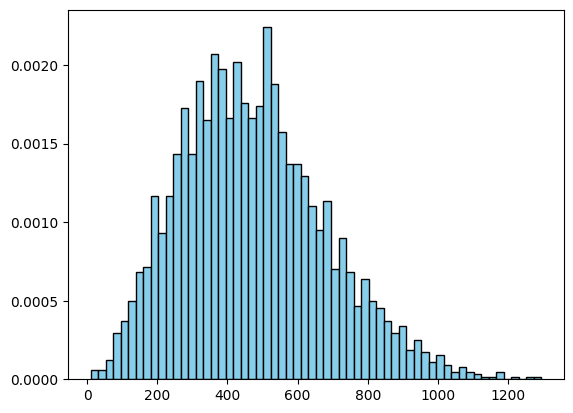

In [515]:
#a)
file = open("Maxwell.csv")
data = pd.read_csv(file)
#b)
histograma = data['Velocidad']
histograma
plt.hist(histograma, density=True, bins=60, color="skyblue", edgecolor="k") #density = True normaliza la frecuencia absoluta

In [516]:
#c)
promedio = np.mean(histograma)
print(f"La velocidad promedio de las moléculas de nitrógeno es {promedio}")


La velocidad promedio de las moléculas de nitrógeno es 472.17578290610606


In [517]:
#d)
def LikelihoodMaxwell(T, v, m=0.028, k=8.31, pi=np.pi):
    return (m/(2*pi*k*T))**(3/2) * (4*pi*v**2) * np.exp(-(m*v**2)/(2*k*T))

La temperatura que da el mejor ajuste es T=297.89


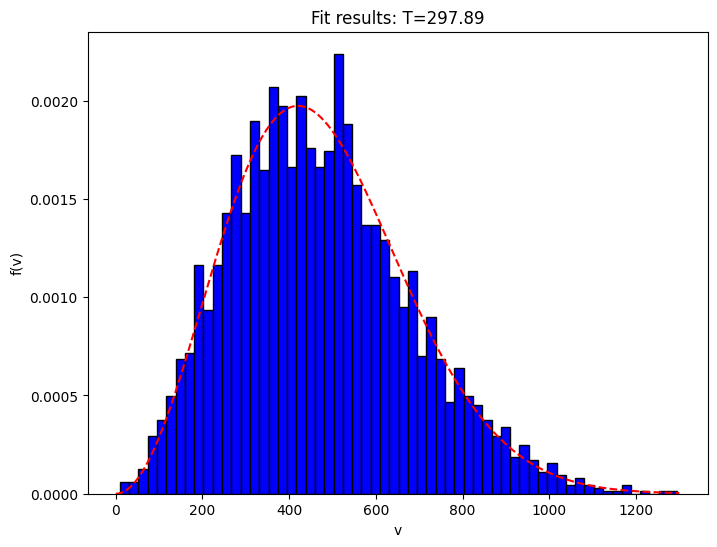

In [518]:
#e) Utilizamos el paquete de optimize para minimizar la función de Likelihood conjunto
def JointLikelihoodMaxwell(T,v):
    return -np.sum(np.log(LikelihoodMaxwell(T,v)))
T0 = 310.0
result = spo.minimize(JointLikelihoodMaxwell,T0,args=(histograma))
T = result.x[0]
print(f"La temperatura que da el mejor ajuste es T={round(T,2)}")
v = np.linspace(0, 1300, 1300)
f = LikelihoodMaxwell(T, v)
plt.figure(figsize=(8, 6))
plt.plot(v, f, linestyle="--", color = "red")
plt.hist(histograma, bins=60, color='blue', edgecolor='black', density=True)
plt.title(f'Fit results: T={round(T,2)}')
plt.xlabel('v')
plt.ylabel('f(v)')
plt.show()

In [519]:
#f)
Vp = np.sqrt(2*8.31*T/0.028)
print(f"La velocidad mas probable es Vp={round(Vp, 2)}")

La velocidad mas probable es Vp=420.5


In [520]:
#g)
Vm = 2*Vp/np.sqrt(np.pi)
print(f"La velocidad promedio es Vm={round(Vm, 2)}")
#No difiere mucho del valor empírico. Lo calculamos antes y fue de 472.18, muy cercano al valor calculado ahora

La velocidad promedio es Vm=474.48


In [521]:
#h)
Vrms = np.sqrt(3*8.31*T/0.028)
print(f"La velocidad cuadrática media es Vrms={round(Vrms, 2)}")

La velocidad cuadrática media es Vrms=515.01


100%|██████████| 1000/1000 [00:05<00:00, 175.15it/s]


La función de distribución posterior del problema está dada por T=298.07 con un error estandar de +4.4K y -4.5K


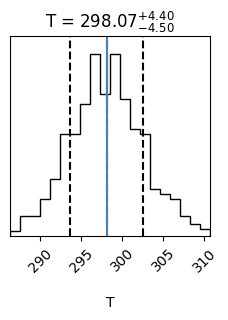

In [522]:
#i)
#Utilizamos Metropolis mediante el paquete emcee
def LogPriorMaxwell(T):
    if 250.0 < T < 350.0:
        return 0.0
    else:
        return -np.inf
    
def JointLikelihoodMaxwellMetropolis(T,v):
    return np.sum(np.log(LikelihoodMaxwell(T,v)))

def LogPosteriorMaxwell(T,v):
    LogP = LogPriorMaxwell(T)
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return LogP + JointLikelihoodMaxwellMetropolis(T,v)

n_walkers, n_params = 10, 1
T0 = np.zeros((n_walkers, n_params))
T0[:,0] = 310.0
T0 += np.random.rand(n_walkers, n_params)
sampler = emcee.EnsembleSampler(n_walkers, n_params, LogPosteriorMaxwell, args=(histograma,))
pos,prob,state = sampler.run_mcmc(T0,1000,progress=True)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
posterior = np.percentile(flat_samples, 50, axis=0)
figure = corner.corner(flat_samples, labels=["T"], truths=posterior, quantiles=[0.16, 0.5, 0.84], show_titles=True)
error_derecha = np.percentile(flat_samples, 84, axis=0)[0] - posterior[0]
error_izquierda = np.percentile(flat_samples, 16, axis=0)[0] - posterior[0]
print(f"La función de distribución posterior del problema está dada por T={round(posterior[0],2)} con un error estandar de +{round(error_derecha,2)}K y {round(error_izquierda,2)}K")

In [523]:
#Usando el modelo de una cola, los modelos que caigan fuera del intervalo de 95% son excluidos:
modelos = np.percentile(flat_samples, 95, axis=0)[0]
print(f"Los modelos que trabajan con una temperatura mayor a {round(modelos,2)}K son excluidos")

Los modelos que trabajan con una temperatura mayor a 306.0K son excluidos


In [524]:
#ESTIMACION DE PARAMETROS: EJERCICIO 10

In [542]:
#a)
file10 = open("HiggsFitting.csv")
data10 = pd.read_csv(file10)

<ErrorbarContainer object of 3 artists>

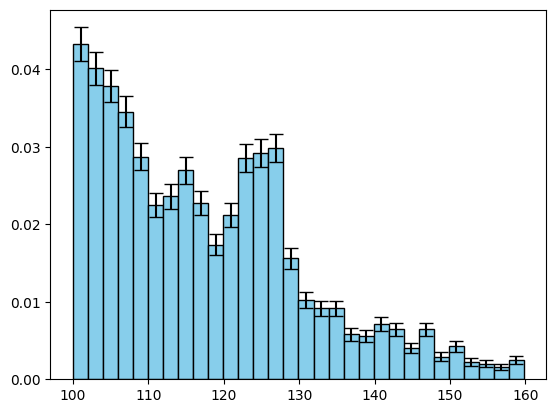

In [526]:
#b)
n = len(data10["Higgs"])
frecuencia, bins, _ = plt.hist(data10["Higgs"].values, bins=30, color="skyblue", edgecolor="k", density=True)
plt.errorbar((bins[:-1] + bins[1:]) / 2, frecuencia, yerr=0.5*np.sqrt(frecuencia/n), fmt='none', ecolor='k', capsize=5)
#Está normalizado

In [527]:
#c)
def LikelihoodH0(alpha, x):
    return np.exp(-(x-100)/alpha)/alpha

In [528]:
#d)
def JointLikelihoodH0(alpha, x):
    return -np.sum(np.log(LikelihoodH0(alpha, x)))

In [529]:
#e)
alpha0 = 23
resultH0 = spo.minimize(JointLikelihoodH0, alpha0, bounds=((0,50), ), args=(data10["Higgs"]))
alpha = resultH0.x[0]
alpha

np.float64(17.618890652801607)

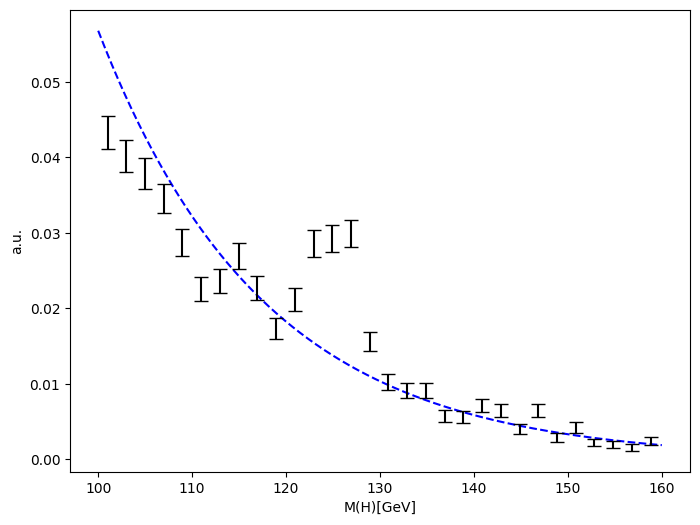

In [530]:
#f)
m = np.linspace(100, 160, 500)
f = LikelihoodH0(alpha, m)
plt.figure(figsize=(8, 6))
plt.plot(m, f, linestyle="--", color = "blue", label="best-fit")
plt.errorbar((bins[:-1] + bins[1:]) / 2, frecuencia, yerr=0.5*np.sqrt(frecuencia/n), fmt='none', ecolor='k', capsize=5)
plt.xlabel('M(H)[GeV]')
plt.ylabel('a.u.')
plt.show()

In [531]:
#g)
def LikelihoodH1(p, x):
    A, u, o, a = p
    return (A*np.exp((-(x-u)**2) / (2*o**2))/np.sqrt(2*np.pi*o**2)) + (1-A)*np.exp(-(x-100) / a)/a 


In [532]:
#h)
def JointLikelihoodH1(p, x):
    return -np.sum(np.log(LikelihoodH1(p, x)))

In [544]:
#i)
p0 = np.array([0.20, 100, 5, 20])
resultH1 = spo.minimize(JointLikelihoodH1, p0, bounds=((0,1), (50,500), (1, 100), (1,100)), args=(data10))
p = resultH1.x
p

array([  0.14212745, 125.19841158,   2.77632069,  16.36325733])

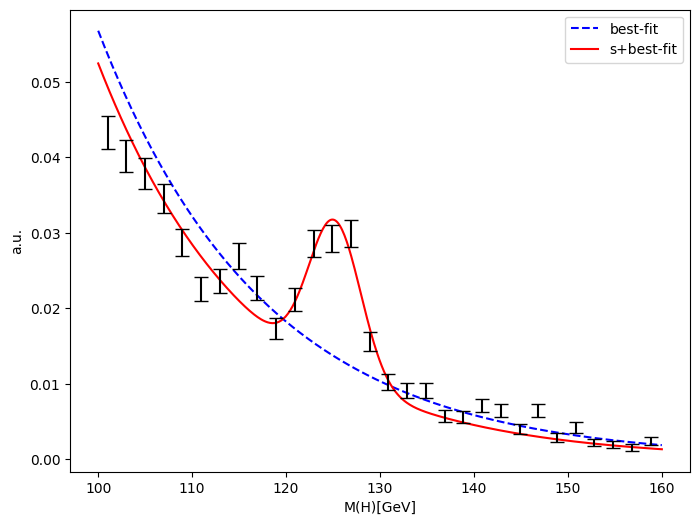

In [545]:
#j)
f1 = LikelihoodH1(p, m)
plt.figure(figsize=(8, 6))
plt.plot(m, f, linestyle="--", color = "blue", label="best-fit")
plt.plot(m, f1, color = "red", label="s+best-fit")
plt.legend()
plt.errorbar((bins[:-1] + bins[1:]) / 2, frecuencia, yerr=0.5*np.sqrt(frecuencia/n), fmt='none', ecolor='k', capsize=5)
plt.xlabel('M(H)[GeV]')
plt.ylabel('a.u.')
plt.show()

In [546]:
#k)
A, u, o, a = np.round(p,3)
print(f"El valor de las constantes físicas son: A={A}, u={u}, o={o}, a={a}")

El valor de las constantes físicas son: A=0.142, u=125.198, o=2.776, a=16.363


In [536]:
#l)
datos = data10["Higgs"].values
n_sigma = np.sqrt(-2*(JointLikelihoodH1(p, datos) - JointLikelihoodH0(alpha, datos)))
print(f"El número de desviaciones estandar entre la observacion y la hipótesis nula es {round(n_sigma, 2)}")

El número de desviaciones estandar entre la observacion y la hipótesis nula es 15.21


In [537]:
#m) 
sigma = o*1.602*10e-10
h = 1.054*10e-34
tiempo = h/sigma
print(f"El tiempo de vida media de Higgs es {tiempo}")


El tiempo de vida media de Higgs es 2.3700561617862395e-25


In [550]:
#n)
def LogPrior(p):
    A, mu, sigma, alpha = p
    if 0. < A < 1. and  100. <= mu <= 300. and 0.1 <= sigma <= 20. and 1 <= alpha <= 50:
        return 0.
    else:
        return -np.inf
def JointLikelihoodH1Metropolis(p, x):
    return -JointLikelihoodH1(p, x)

def LogPosteriorH1(p, x):
    LogP = LogPrior(p)
    if not np.isfinite(LogP):
        return -np.inf
    else:
        return LogP + JointLikelihoodH1Metropolis(p,x)
n_walkers, n_params = 15, 4
p0_emcee = np.zeros((n_walkers, n_params))
p0_emcee[:,0] = 0.14
p0_emcee[:,1] = 125
p0_emcee[:,2] = 3
p0_emcee[:,3] = 16
p0_emcee += np.random.rand(n_walkers, n_params)
sampler = emcee.EnsembleSampler(n_walkers, n_params, LogPosteriorH1, args=(datos,))
pos,prob,state = sampler.run_mcmc(p0_emcee,1000,progress=True)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
posterior = np.percentile(flat_samples, 50, axis=0)
error_derecha = np.percentile(flat_samples, 84, axis=0) - posterior
error_izquierda = np.percentile(flat_samples, 16, axis=0) - posterior
print(f"El error para el parametro A es de +{error_derecha[0]} y {error_izquierda[0]}")
print(f"El error para el parametro u es de +{error_derecha[1]} y {error_izquierda[1]}")
print(f"El error para el parametro o es de +{error_derecha[2]} y {error_izquierda[2]}")
print(f"El error para el parametro a es de +{error_derecha[3]} y {error_izquierda[3]}")

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:02<00:00, 378.06it/s]

El error para el parametro A es de +0.015405526862841495 y -0.013016580502805075
El error para el parametro u es de +0.2817337281838945 y -0.2863335069024089
El error para el parametro o es de +0.4209690956129051 y -0.37709695348986605
El error para el parametro a es de +0.39399928101872916 y -0.3657181835503973


Text(0.5, 0, 'step number')

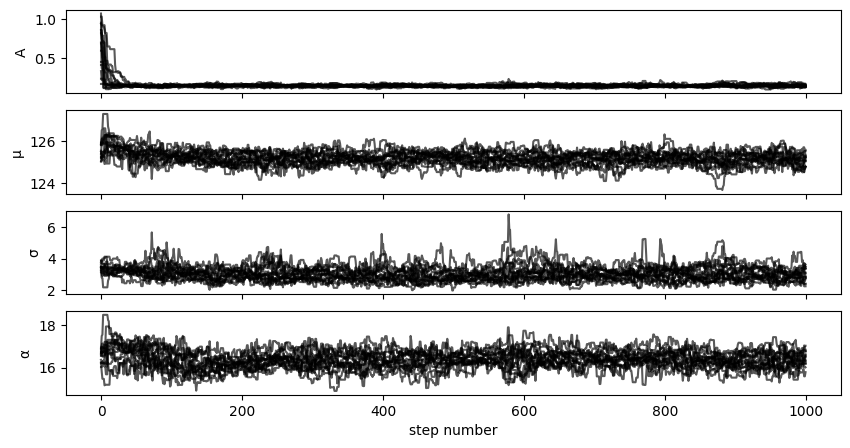

In [551]:
#o)
fig, axes = plt.subplots(4, figsize=(10,5), sharex=True)
samples = sampler.get_chain()
labels = ["A", "μ", "σ", "α"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.65)
    ax.set_ylabel(labels[i])
ax.set_xlabel("step number")

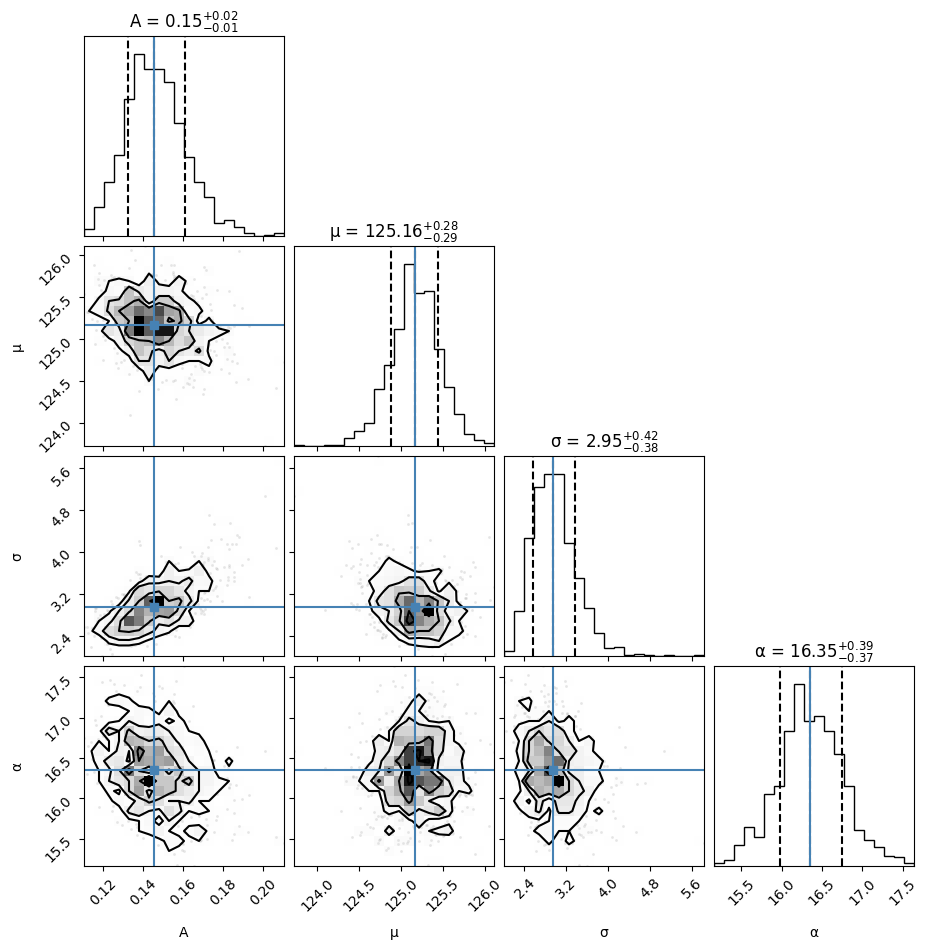

In [552]:
figure = corner.corner(flat_samples, labels=labels, truths=posterior, quantiles=[0.16, 0.5, 0.84], show_titles=True)

In [541]:
#p)
error_promedio = (error_derecha[1] + np.abs(error_izquierda[1]))/2
print(f"El error porcentual en la estimación de la masa de Higgs es {error_promedio*100/posterior[1]}%")

El error porcentual en la estimación de la masa de Higgs es 0.2548600189435164%


In [553]:
#HYPOTHESIS TESTING: EJERCICIO 4

In [625]:
#a)
N = 1000 #De fotones
pasos = []
l = 0.1
for n in range(N):
    x, y, z = 0., 0., 0.
    conteo = 0
    while np.sqrt(x**2 + y**2 + z**2) <= 1:
        phi = np.random.uniform(0,np.pi)
        theta = np.random.uniform(0,2*np.pi)
        x += l*np.cos(theta)*np.sin(phi)
        y += l*np.sin(theta)*np.sin(phi)
        z += l*np.cos(phi)
        conteo += 1
    pasos.append(conteo)
pasos = np.array(pasos)

In [581]:
#b)
min = np.min(pasos)
max = np.max(pasos)
clases = np.linspace(min, max, 21) #20 Clases para la distribución

In [626]:
#c)
frecuencias, bin_edges = np.histogram(pasos, bins=clases) #Construimos la distribución
frecuencias_relativas = frecuencias/np.sum(frecuencias) #Normalizamos


(array([4.45335115e-03, 8.59418642e-03, 7.85196123e-03, 5.58622118e-03,
        4.45335115e-03, 2.34386902e-03, 1.91415970e-03, 9.37547610e-04,
        1.01567658e-03, 6.64096224e-04, 4.29709321e-04, 2.34386902e-04,
        7.81289675e-05, 1.56257935e-04, 7.81289675e-05, 3.90644837e-05,
        1.17193451e-04, 3.90644837e-05, 0.00000000e+00, 0.00000000e+00]),
 array([ 17.  ,  42.65,  68.3 ,  93.95, 119.6 , 145.25, 170.9 , 196.55,
        222.2 , 247.85, 273.5 , 299.15, 324.8 , 350.45, 376.1 , 401.75,
        427.4 , 453.05, 478.7 , 504.35, 530.  ]),
 <BarContainer object of 20 artists>)

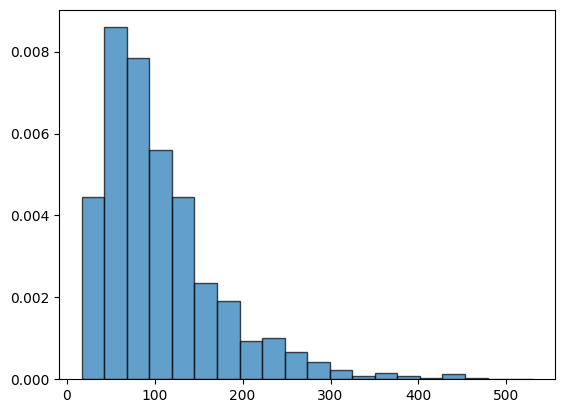

In [627]:
#d)
plt.hist(pasos, bins=bin_edges, edgecolor='k', alpha=0.7, density=True) #Density=True dibuja la distribución como aparece en el enunciado.

In [628]:
#e)
m = []
for i in range(len(bin_edges)-1):
    m.append((bin_edges[i] + bin_edges[i+1])/2)
print(f"El número de pasos esperado son {np.sum(frecuencias_relativas*m)}")

El número de pasos esperado son 106.67219438877754


In [629]:
#f) El anterior valor calculado es aproximademente el valor medio
#Comparemoslo con el siguiente:
Rs = 1
E = (Rs/l)**2
E


100.0

In [630]:
#Vemos que el numero de pasos medio calculado en e) es parecido al calculado en f)
#Además, también es muy parecido a la media calculada a mano:
np.mean(pasos)

np.float64(106.195)

In [631]:
#g)
Rs = 700000*1000
c = 300000*1000
l = 0.6/100
T = (Rs**2)/(l*c)
años = T/31536000
print(f"A un fotón le toma {años} años escapar")

A un fotón le toma 8632.110040024805 años escapar


(array([4.45335115e-03, 8.59418642e-03, 7.85196123e-03, 5.58622118e-03,
        4.45335115e-03, 2.34386902e-03, 1.91415970e-03, 9.37547610e-04,
        1.01567658e-03, 6.64096224e-04, 4.29709321e-04, 2.34386902e-04,
        7.81289675e-05, 1.56257935e-04, 7.81289675e-05, 3.90644837e-05,
        1.17193451e-04, 3.90644837e-05, 0.00000000e+00, 0.00000000e+00]),
 array([ 17.  ,  42.65,  68.3 ,  93.95, 119.6 , 145.25, 170.9 , 196.55,
        222.2 , 247.85, 273.5 , 299.15, 324.8 , 350.45, 376.1 , 401.75,
        427.4 , 453.05, 478.7 , 504.35, 530.  ]),
 <BarContainer object of 20 artists>)

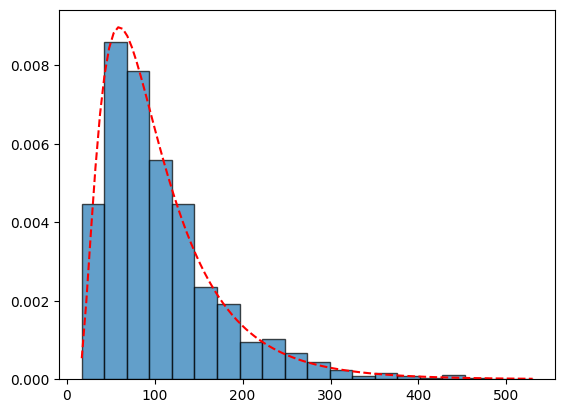

In [633]:
#h)
a,c,d,e = exponweib.fit(pasos)
para_graficar = np.linspace(min, max, 100)
pdf_values = exponweib.pdf(para_graficar, a, c, d, e)
plt.plot(para_graficar, pdf_values, linestyle="--", color="red")
plt.hist(pasos, bins=bin_edges, edgecolor='k', alpha=0.7, density=True)